<a href="https://colab.research.google.com/github/lrincon66/Computational_chemistry/blob/main/sa_lj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Import libraries
import numpy as np                           # python ecosystem for scientific computing
from scipy.optimize import minimize          # scipy unconstrained minimization
import matplotlib.pyplot as plt

In [5]:
def ene_lj(x):
    """The Lennard-Jones Potential"""
    natoms = int(len(x)/3)                                        # number of atoms
    ene = 0.0
    for i in range(natoms-1):
        for j in range(i+1,natoms):                                # loop over atoms pairs
            xr = x[3*i] - x[3*j]
            yr = x[3*i+1] - x[3*j+1]
            zr = x[3*i+2] - x[3*j+2]
            r2 = np.power(xr,2) + np.power(yr,2) + np.power(zr,2)
            r2i = 1.0/r2
            r6i = np.power(r2i,3)
            ene = ene + 4.0*r6i*(r6i-1.0)                         # update energy
    return ene

In [6]:
def dene_lj(x):
    """The Lennard-Jones gradient vector"""
    natoms = int(len(x)/3)                                         # number of atoms
    dene = np.zeros_like(x)                                    # set gradient to zero
    for i in range(natoms-1):
        for j in range(i+1,natoms):                                # loop over atoms pairs
            xr = x[3*i] - x[3*j]
            yr = x[3*i+1] - x[3*j+1]
            zr = x[3*i+2] - x[3*j+2]
            r2 = np.power(xr,2) + np.power(yr,2) + np.power(zr,2)
            r2i = 1.0/r2
            r6i = np.power(r2i,3)
            df = -48.0*r2i*r6i*(r6i-0.5)
            dene[3*i] = dene[3*i] + df*xr                     # update gradients
            dene[3*i+1] = dene[3*i+1] + df*yr
            dene[3*i+2] = dene[3*i+2] + df*zr
            dene[3*j] = dene[3*j] - df*xr
            dene[3*j+1] = dene[3*j+1] - df*yr
            dene[3*j+2] = dene[3*j+2] - df*zr
    return dene

In [7]:
n = 13                                                    # set the number of atoms
rc = 0.45*np.power(float(n),1.0/3.0)
x = np.zeros(3*n)
np.random.seed()

x[0] = rc*(2.0*np.random.rand()-1.0)
x[1] = rc*(2.0*np.random.rand()-1.0)
x[2] = rc*(2.0*np.random.rand()-1.0)
x_mean = x[0]
y_mean = x[1]
z_mean = x[2]

for i in range(1,n):
    check = True
    while check:
        check = False
        x[3*i] = rc*(2.0*np.random.rand()-1.0)
        x[3*i+1] = rc*(2.0*np.random.rand()-1.0)
        x[3*i+2] = rc*(2.0*np.random.rand()-1.0)
        for j in range(i):
            dx = x[3*i]-x[3*j]
            dy = x[3*i+1]-x[3*j+1]
            dz = x[3*i+2]-x[3*j+2]
            rij = np.sqrt(np.power(dx,2)+np.power(dy,2)+np.power(dz,2))
            if rij<=1.0:
                check=True
    x_mean = x_mean + x[3*i]
    y_mean = y_mean + x[3*i+1]
    z_mean = z_mean + x[3*i+2]

for i in range(n):
    x[3*i] = x[3*i]-(x_mean/n)
    x[3*i+1] = x[3*i+1]-(y_mean/n)
    x[3*i+2] = x[3*i+2]-(z_mean/n)
    rij = np.sqrt(np.power(x[3*i],2)+np.power(x[3*i+1],2)+np.power(x[3*i+2],2))
    print(x[3*i],x[3*i+1],x[3*i+2],rij)

0.750153065662384 0.023072667816868203 -0.17232639407433792 0.7700378925855043
0.7776497661572376 1.163355934878264 -0.9055818854908891 1.6667977505834715
-0.9786302707767703 -0.5112065459871147 -0.32087515066277217 1.1497870245630482
0.5877687769795691 0.7725902686076375 0.5904110015322555 1.1362011305528614
-0.8875362982085705 1.0839058812668596 -0.02719800726143551 1.40118249049924
0.10791944329663242 -0.613555696279799 0.6709818388590527 0.9155947939768552
-0.7425701791853357 0.6380354854167052 -0.9531728836433425 1.3663960984206729
-0.07767689013695687 -0.8700351150335565 -0.8158196350345434 1.195222354861512
-0.5636088182359092 0.40862523045895804 1.0642501339339565 1.2717145224221351
-0.2207828518925929 0.2542862280595017 -0.05858971607342761 0.34181765358173116
1.1050341402932322 -0.8008522874360232 1.0868841915765037 1.744643827090224
1.0686934299791828 -0.8644093657739303 -0.8403448211864007 1.611052021945028
-0.9264133139321027 -0.6838126859943708 0.6813813275253805 1.337954

In [8]:
chi = 0.999
temp = 0.60
temp_min = 0.01
n_mc = 20*n
ene = ene_lj(x)
min_ene = ene
min_x = np.zeros(3*n)
min_x = x
delx = 0.010
t = []
e_mean = []
e_min = []
cp = []
print(ene/n)
while temp>temp_min:
    mean_ene = 0.0
    mean_ene2 = 0.0
    for j in range(n_mc):
        o = np.random.randint(n)
        xn = x[3*o] + (2.0*np.random.rand()-1.0)*delx
        yn = x[3*o+1] + (2.0*np.random.rand()-1.0)*delx
        zn = x[3*o+2] + (2.0*np.random.rand()-1.0)*delx
        dene = 0.0
        for ix in range(n):
            if ix!=o:
                xro = x[3*o] - x[3*ix]
                yro = x[3*o+1] - x[3*ix+1]
                zro = x[3*o+2] - x[3*ix+2]
                xrn = xn - x[3*ix]
                yrn = yn - x[3*ix+1]
                zrn = zn - x[3*ix+2]
                r2o = np.power(xro,2) + np.power(yro,2) + np.power(zro,2)
                r2n = np.power(xrn,2) + np.power(yrn,2) + np.power(zrn,2)
                r2io = 1.0/r2o
                r2in = 1.0/r2n
                r6io = np.power(r2io,3)
                r6in = np.power(r2in,3)
                dene = dene + 4.0*r6in*(r6in-1.0) - 4.0*r6io*(r6io-1.0)
        prob = np.exp(-dene/temp)
        if prob>np.random.rand():
            ene = ene + dene
            x[3*o] = xn
            x[3*o+1] = yn
            x[3*o+2] = zn
            if ene < min_ene:
                min_x = x
                min_ene = ene
        mean_ene = mean_ene + ene
        mean_ene2 = mean_ene2 + ene**2
    print(temp,mean_ene/n_mc,min_ene) 
    t.append(temp)
    e_mean.append(mean_ene/n_mc)
    e_min.append(min_ene)
    cp.append(np.power(((mean_ene2/n_mc)-((mean_ene/n_mc)**2))/(temp**2),2))
    temp = chi*temp

-1.7937470633208492
0.6 -23.084600214671358 -23.922753229841227
0.5993999999999999 -22.831673439145963 -23.922753229841227
0.5988005999999999 -24.083550527032635 -24.652986218435746
0.5982017994 -24.405800537663605 -24.784164536031785
0.5976035976006 -23.80259455058466 -24.784164536031785
0.5970059940029994 -23.608280577022658 -24.784164536031785
0.5964089880089963 -24.593440365241474 -24.941434906660263
0.5958125790209874 -24.348621064377465 -24.941434906660263
0.5952167664419664 -24.548989884701818 -24.953350267144657
0.5946215496755245 -23.824345883644998 -24.953350267144657
0.594026928125849 -22.89053459037376 -24.953350267144657
0.5934329011977232 -22.62396382507392 -24.953350267144657
0.5928394682965255 -23.833949882831266 -24.953350267144657
0.5922466288282289 -24.557340052230717 -25.06103028183701
0.5916543821994007 -24.57332622871854 -25.268747224331943
0.5910627278172013 -24.778636236159556 -25.46566678918674
0.5904716650893841 -24.969568027660895 -25.46566678918674
0.5898811

In [9]:
opt = minimize(ene_lj,x, method='BFGS', jac=dene_lj, options={'disp': True})
x = opt.x

Optimization terminated successfully.
         Current function value: -41.394398
         Iterations: 41
         Function evaluations: 53
         Gradient evaluations: 53


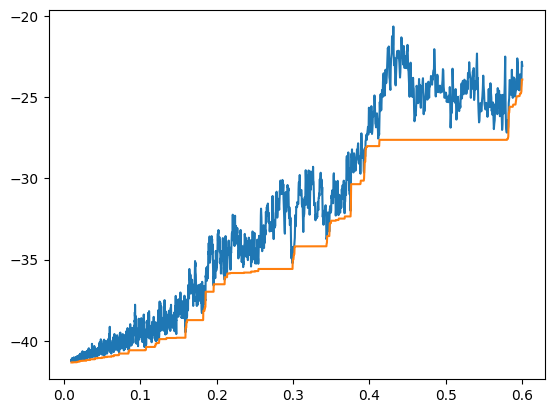

In [10]:
plt.plot(t,e_mean)
plt.plot(t,e_min)
plt.show()

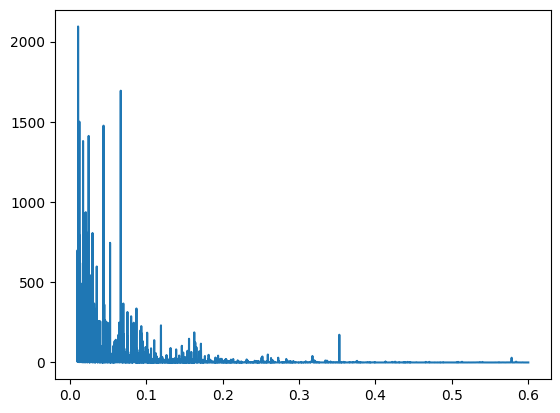

In [11]:
plt.plot(t,cp)
plt.show()